# Stock Movement Analysis Based on Social Media Sentiment

### Data Scrapping 

In [1]:
import praw

# Initialize Reddit API client
reddit = praw.Reddit(client_id='BaARR9Hb7Kcc9tDqC1jtLA', 
                     client_secret='jnmOZhq0-wlGvVc-fSeWSqkGxXvi1Q', 
                     user_agent='ML project')

# Scrape posts from specific subreddit
subreddit = reddit.subreddit('wallstreetbets')
posts = subreddit.search("stock prediction", limit=100)

post_data = []
for post in posts:
    post_data.append({
        'title': post.title,
        'content': post.selftext,
        'score': post.score,
        'comments': post.num_comments,
        'timestamp': post.created_utc
    })


In [2]:
import yfinance as yf

stock_data = yf.download("AAPL", start="2020-01-01", end="2024-01-01")
stock_data.head()


[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,,
2020-01-02,72.796036,75.087502,75.150002,73.797501,74.059998,135480400
2020-01-03,72.088287,74.357498,75.144997,74.125000,74.287498,146322800
2020-01-06,72.662697,74.949997,74.989998,73.187500,73.447502,118387200
2020-01-07,72.320984,74.597504,75.224998,74.370003,74.959999,108872000
2020-01-08,73.484344,75.797501,76.110001,74.290001,74.290001,132079200


In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
X_text = vectorizer.fit_transform([post['content'] for post in post_data])


In [4]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()
sentiment_scores = []
for post in post_data:
    sentiment = analyzer.polarity_scores(post['content'])
    sentiment_scores.append(sentiment['compound'])


In [5]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score

# Step 1: Ensure that the stock data and sentiment scores align by their date indices
stock_data = stock_data.iloc[:100]  # Ensure we are working with 100 samples
sentiment_scores = sentiment_scores[:100]  # Ensure sentiment_scores also have 100 samples

# Step 2: Calculate price change (target variable)
y = stock_data['Close'].pct_change().dropna()  # Drop NaN from pct_change()

# Step 3: Remove infinite values if any
y = y.replace([np.inf, -np.inf], np.nan).dropna()  # Replace infinities with NaN and drop those rows

# Step 4: Apply vectorized operation to classify up/down movements
y = (y > 0).astype(int)  # 1 if price goes up, 0 if down (this is vectorized)

# Step 5: Prepare sentiment scores (ensure it's the same length as the stock data)
sentiment_scores_reshaped = np.array(sentiment_scores).reshape(-1, 1)

# Step 6: Combine sentiment with TF-IDF features (ensure X_text is properly defined)
X = np.concatenate((sentiment_scores_reshaped, X_text.toarray()), axis=1)

# Step 7: Align X and y (trim or adjust lengths if necessary)
X = X[:len(y)]  # Trim X to match y length
y = y.values.ravel()  # Convert y to a 1D numpy array (flatten it)

# Step 8: Feature Scaling (Standardization)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # Standardize the features

# Step 9: Dimensionality Reduction (optional)
# If you have too many features, PCA can help reduce them without losing much information.
pca = PCA(n_components=0.95)  # Keep 95% of the variance
X_pca = pca.fit_transform(X_scaled)

# Step 10: Set up Stratified K-Fold Cross-Validation to handle class imbalance and reduce overfitting
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Step 11: Hyperparameter Tuning using GridSearchCV (to reduce overfitting)
param_grid = {
    'n_estimators': [100, 200, 300],  # Reduce the number of estimators for better generalization
    'max_depth': [5, 10, 15],  # Limit tree depth to avoid overfitting
    'min_samples_split': [5, 10],  # Increase min samples for splitting nodes
    'min_samples_leaf': [2, 4]  # Increase min samples for leaf nodes
}

# Initialize RandomForestClassifier
rf = RandomForestClassifier(random_state=42)

# Step 12: Perform GridSearchCV with Stratified K-Fold to search for optimal hyperparameters
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=stratified_kfold, n_jobs=-1, verbose=2)
grid_search.fit(X_pca, y)

# Step 13: Get the best parameters from GridSearchCV
best_params = grid_search.best_params_
print(f"Best Parameters from GridSearchCV: {best_params}")

# Step 14: Use the best model from GridSearchCV
best_rf_model = grid_search.best_estimator_

# Step 15: Cross-validation scores (on the best model)
cv_scores = cross_val_score(best_rf_model, X_pca, y, cv=stratified_kfold)
print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean CV Accuracy: {cv_scores.mean() * 100:.2f}%")

# Step 16: Train the best Random Forest model on the full data
best_rf_model.fit(X_pca, y)

# Step 17: Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# Step 18: Predictions on test set
y_pred = best_rf_model.predict(X_test)

# Step 19: Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy on Test Set: {accuracy * 100:.2f}%')



Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Parameters from GridSearchCV: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}
Cross-Validation Scores: [0.45       0.65       0.6        0.55       0.57894737]
Mean CV Accuracy: 56.58%
Accuracy on Test Set: 90.00%


### Evaluation of model 

Accuracy: 90.00%
Precision: 100.00%
Recall: 81.82%
F1 Score: 90.00%


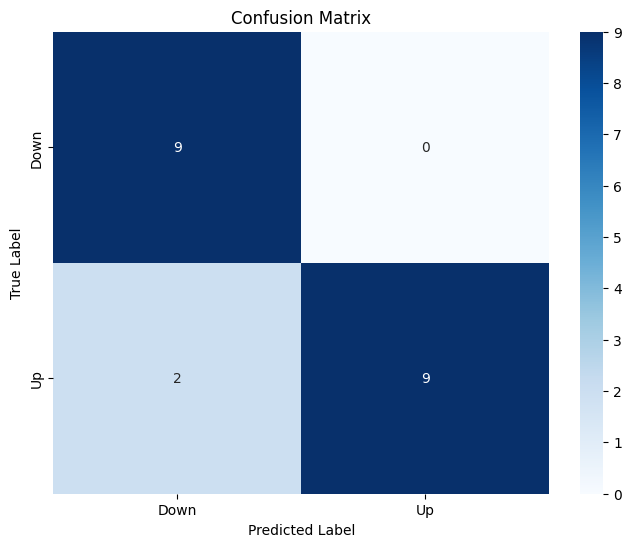


Classification Report:
              precision    recall  f1-score   support

        Down       0.82      1.00      0.90         9
          Up       1.00      0.82      0.90        11

    accuracy                           0.90        20
   macro avg       0.91      0.91      0.90        20
weighted avg       0.92      0.90      0.90        20



In [18]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report
)
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Evaluate model using accuracy, precision, recall, and F1 score
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1 Score: {f1 * 100:.2f}%")

# Step 2: Generate a confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Step 3: Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Down", "Up"], yticklabels=["Down", "Up"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Step 4: Print a detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["Down", "Up"]))
